In [11]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
rng = core.GSLRandomNumberGenerator()

phios = [0.2]#[0.05,0.1,0.18]
simrun = 1
phit = 0.001
L = 0.2
Vt = L**3
rm = 0.005
Vp = 4./3*math.pi*rm**3
Nt = int(phit*Vt/Vp)
if (Nt==0): print 'no tracer'
Do = 0
Dt = 1    
rv = rm#1.66097*rm
H = 3*rv*2
dt = (2*rv)**2 / (6*Dt)
tt = np.logspace(math.log10(2.1*dt),-1,15)
tt = np.insert(tt,0,dt)
tt = np.insert(tt,0,0.)
dur = tt[-1]
print 'L={},rm={},rv={},Do={},Dt={},dt={}'.format(L,rm,rv,Do,Dt,dt)
w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv)
rs = w.row_size()
ls = w.layer_size()
cs = w.col_size()
Nmv = cs*ls*rs
x,y,z = tuple(w.actual_lengths())
print 'defined volume',L**3
print 'actual volume',y*z*x
print 'no of voxels',Nmv

def run(phio):
    msd = np.zeros(len(tt),float)
    w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rv)
    x,y,z = w.actual_lengths()
    with species_attributes():
        O | {'D':str(Do),'radius':str(rv)}
        T | {'D':str(Dt),'radius':str(rv)}
    m=get_model()
    w.bind_to(m)
    #w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
    w.add_molecules(Species('T'),Nt)
    w.add_molecules(Species('O'),No)
    sim = spatiocyte.SpatiocyteSimulator(w)
    pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
    #obs = FixedIntervalTrajectoryObserver(dt,pids)
    obs = TimingTrajectoryObserver(tt,pids,True,dt)
    sim.run(dur,obs)
    data=obs.data()
    #viz.plot_trajectory(obs)
    for i in range(Nt):
        #print 'tracer',i
        msd += np.array(
            [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                 for pos in data[i]]) 

    #msd = msd/Nt
    return msd

L=0.2,rm=0.005,rv=0.005,Do=0,Dt=1,dt=1.66666666667e-05
defined volume 0.008
actual volume 0.00970716189213
no of voxels 13728


phio 0.2
occupancy of tracer 0.000981747704247 occupancy of obstacles 0.199949282432
Nt 15 No 3055
total traj 15


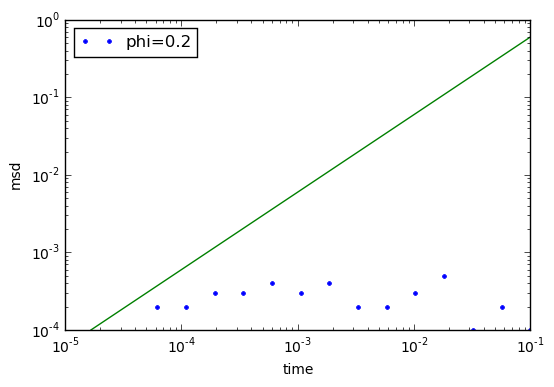

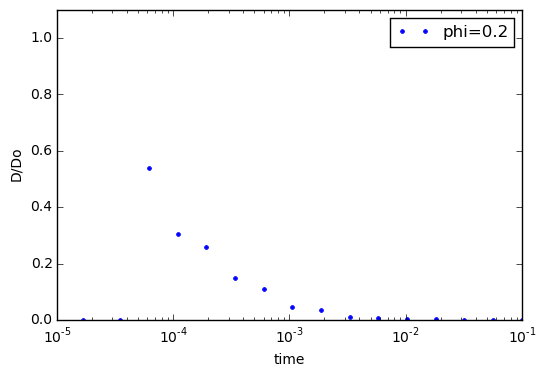

In [12]:
f1,ax1 = plt.subplots(1)
f2,ax2 = plt.subplots(1)
Deffall = []
for phio in phios:
    print 'phio',str(phio)
    No = int(phio*Vt/Vp)
    print 'occupancy of tracer',Nt*Vp/Vt,'occupancy of obstacles',No*Vp/Vt
    phi_hcp = float(No)/Nmv
    #print 'phi_hcp/phi_BD=',str(phi_hcp/phio)
    print 'Nt',Nt,'No',No
    MSD = []
    print 'total traj',simrun*Nt
    for rr in range(simrun):
        #print 'run',rr
        msdr = run(phio)
        MSD.append(msdr)
    MSD = np.array(MSD)
    MSD = np.mean(MSD,axis=0)
    #fn = open('data/2Dcrowding_LS_phi'+str(phio)+'rv1.54rm.csv','w')
    #np.savetxt(fn,np.column_stack((t,MSD)),delimiter=',',fmt='%s')
    #fn.close()
    ax1.loglog(tt,MSD,'.',label='phi='+str(phio))
    ax1.plot(tt,6*Dt*tt,'g-')  #theoretical line
    ax1.set_xlabel("time")
    ax1.set_ylabel("msd")
    Deff = MSD[1:]/tt[1:]/6/Dt
    ax2.semilogx(tt[1:],Deff,'.',label='phi='+str(phio))
    ax2.set_xlabel("time")
    ax2.set_ylabel("D/Do")
    ax2.set_ylim(0,1.1)
    Deffall.append(Deff)
ax1.legend(loc='best')
ax2.legend(loc='best') 
plt.show()
Deffall = np.array(Deffall)
Deffs=[]
for dff in Deffall:
    Deffs.append(np.mean(dff[(tt>.2)[1::]]))

In [7]:
f1.savefig("figure/2DLSphir_diffusion_MSD_t.png",format='png',dpi=100)    
f2.savefig("figure/2DLSphir_diffusion_Deff_t.png",format='png',dpi=100)

In [5]:
Deffs

[0.75305785376494638,
 0.44457121129333504,
 0.15132287822750226,
 0.019633047966775903]

phi= 0.05  Deff= 0.753057853765
phi= 0.1  Deff= 0.444571211293
phi= 0.15  Deff= 0.151322878228
phi= 0.18  Deff= 0.0196330479668


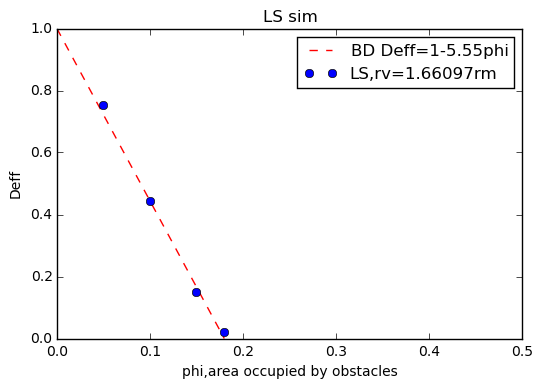

In [6]:
from ecell4 import *
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
%matplotlib inline
phios = [0.05,0.1,0.15,0.18]
#phir = [0.,0.0906,0.1813,0.272,0.3627]
Deffs =[0.75305785376494638, 0.44457121129333504, 0.15132287822750226, 0.019633047966775903]
#phiobd = [0, 0.05,0.1,0.15,0.18,0.2]
#Deffbd = [0.94830140592077317, 0.67515725372187418, 0.42724170618727503, 0.20667644039049163, 0.081817752936242369, 0.032423098951908771]
xx = np.linspace(0,0.18,10)
plt.plot(xx,[(-1./0.18)*i+1. for i in xx],'r--',label='BD Deff=1-5.55phi')
plt.plot(phios,Deffs,'bo',label='LS,rv=1.66097rm')
#plt.plot(phiobd,Deffbd,'ro-',label='BD')
plt.title('LS sim')
plt.xlabel('phi,area occupied by obstacles')
plt.ylabel('Deff')
plt.xlim(0,0.5)
plt.ylim(0.0,1)
plt.legend(loc='best')
for i,j in zip(phios,Deffs):
    print 'phi=',str(i),' Deff=',str(j)
plt.savefig("figure/2DLSBD_diffusion_Deff_phir.png",format='png',dpi=100)
plt.show()

In [31]:
Nos = [31194, 62388 ,93583, 112299, 124777]
phil = [float(i)/206912 for i in Nos]
print phil
for i,j in zip(phios[1:],phil):
    print 'phi_hcp/phi_BD',j/i
print 0.5/0.18
print 'area=',49,'lattice area=',str(7.011272387006512*7.03416)

[0.15075974327250233, 0.30151948654500466, 0.45228406278997835, 0.5427379755644912, 0.6030438060624806]
phi_hcp/phi_BD 3.01519486545
phi_hcp/phi_BD 3.01519486545
phi_hcp/phi_BD 3.01522708527
phi_hcp/phi_BD 3.01521097536
phi_hcp/phi_BD 3.01521903031
2.77777777778
area= 49 lattice area= 49.3184117738
